<a href="https://colab.research.google.com/github/nadya-58/MIDRC_colab/blob/main/MIDRC_BPR_by_series_not_shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

We have a copy of MIDRC data under `idc-external-019`, the data is in a DICOM store. This notebook illustrates how to use metadata extracted into BigQuery to retrive selected series via the DICOMweb interface.

In [ ]:
!gcloud config set project idc-external-019

Updated property [core/project].


https://console.cloud.google.com/storage/browser/midrc-analysis;tab=objects?forceOnBucketsSortingFiltering=false&project=idc-external-019&prefix=&forceOnObjectsSortingFiltering=false

## Preliminary
First you need to login.  This will give you a link that you can use to get a verification code.  

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
#!gcloud auth login


You are running on a Google Compute Engine virtual machine.
It is recommended that you use service accounts for authentication.

You can run:

  $ gcloud config set account `ACCOUNT`

to switch accounts if necessary.

Your credentials may be visible to others with access to this
virtual machine. Are you sure you want to authenticate with
your personal account?

Do you want to continue (Y/n)?  

Command killed by keyboard interrupt

^C


**Install BodyPartRegression package**

In [ ]:
#%%capture 
import shutil
import os
if os.path.isdir('/content/BodyPartRegression'):
  shutil.rmtree('/content/BodyPartRegression')
!pip install torch==1.8.1 pytorch-lightning==1.2.10 torchtext==0.9.1 torchvision==0.9.1 torchaudio==0.8.1 dataclasses==0.6
!pip install bpreg
!git clone https://github.com/MIC-DKFZ/BodyPartRegression.git
# !pip install torch==1.8.1 pytorch-lightning==1.2.10 torchtext==0.9.1
!pip install SimpleITK
!pip install pydicom

import bpreg 
import seaborn as sb 
import pandas as pd 
import SimpleITK as sitk
import glob
import matplotlib.pyplot as plt 

!pip install opencv-python-headless==4.1.2.30 # https://stackoverflow.com/questions/70537488/cannot-import-name-registermattype-from-cv2-cv2/70547274
from BodyPartRegression.docs.notebooks.utils import * 

print (pd.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
     |████████████████████████████████| 841 kB 36.9 MB/s 
     |████████████████████████████████| 7.1 MB 37.9 MB/s 
     |████████████████████████████████| 17.4 MB 752 kB/s 
     |████████████████████████████████| 1.9 MB 45.2 MB/s 
     |████████████████████████████████| 829 kB 57.3 MB/s 
     |████████████████████████████████| 596 kB 27.6 MB/s 
     |████████████████████████████████| 141 kB 55.0 MB/s 
     |████████████████████████████████| 176 kB 60.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=dc1c3fb21e242f7a73d086d6c13bfdb4d8e7be7111594f3f03d5ac6f40502125
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninsta

**Define the list of SOPInstanceUIDs for the series of interest by getting CT series from the DICOM Store using BigQuery SQL**

In [ ]:
%%bigquery --project=idc-external-019 ct_limited_open_a1_r1

WITH
  nlst_instances_per_series AS (
    SELECT
      DISTINCT(StudyInstanceUID),
      SeriesInstanceUID,
      COUNT(DISTINCT(SOPInstanceUID)) AS num_instances,
      COUNT(DISTINCT(ARRAY_TO_STRING(ImagePositionPatient,"/"))) AS position_count,
      COUNT(DISTINCT(ARRAY_TO_STRING(ImageOrientationPatient,"/"))) AS orientation_count,
      MIN(SAFE_CAST(SliceThickness AS float64)) AS min_SliceThickness,
      MAX(SAFE_CAST(SliceThickness AS float64)) AS max_SliceThickness,
      MIN(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as min_SliceLocation, 
      MAX(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as max_SliceLocation,
      STRING_AGG(DISTINCT(SAFE_CAST("LOCALIZER" IN UNNEST(ImageType) AS string)),"") AS has_localizer
    FROM
      idc-external-019.midrc_dicom_us.dicom_all
    WHERE
      (collection_id = "Open-R1" or collection_id = "Open-A1") and Modality = "CT"
    GROUP BY
      StudyInstanceUID,
      SeriesInstanceUID
      ), 
  nlst_values_per_series AS (
    SELECT 
    dicom_all.StudyInstanceUID AS StudyInstanceUID,
    ANY_VALUE(dicom_all.PatientID) AS PatientID,
    ANY_VALUE(dicom_all.SeriesInstanceUID) AS SeriesInstanceUID,
    ANY_VALUE(nlst_instances_per_series.num_instances) AS num_instances,
    ANY_VALUE(nlst_instances_per_series.max_SliceThickness) AS SliceThickness,
    ANY_VALUE((nlst_instances_per_series.max_SliceLocation - nlst_instances_per_series.min_SliceLocation)) AS PatientHeightScanned
  FROM
    idc-external-019.midrc_dicom_us.dicom_all AS dicom_all
  JOIN
    nlst_instances_per_series
  ON
    dicom_all.SeriesInstanceUID = nlst_instances_per_series.SeriesInstanceUID
  WHERE
    min_SliceThickness >= 1.5 
    AND max_SliceThickness <= 3.5 
    AND nlst_instances_per_series.num_instances > 100
    AND nlst_instances_per_series.num_instances/nlst_instances_per_series.position_count = 1
    AND nlst_instances_per_series.orientation_count = 1
    AND has_localizer = "false"
  GROUP BY
    StudyInstanceUID
  )
  SELECT 
    dicom_all.PatientID,
    dicom_all.StudyInstanceUID,
    dicom_all.SeriesInstanceUID,
    dicom_all.SOPInstanceUID,
    dicom_all.collection_id,
    dicom_all.PatientAge,
    dicom_all.PatientWeight,
    nlst_values_per_series.num_instances,
    nlst_values_per_series.SliceThickness,
    nlst_values_per_series.PatientHeightScanned
  FROM
    idc-external-019.midrc_dicom_us.dicom_all AS dicom_all
  JOIN
    nlst_values_per_series 
  ON
    dicom_all.SeriesInstanceUID = nlst_values_per_series.SeriesInstanceUID

In [ ]:
ct_limited_open_a1_r1

,PatientID,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,collection_id,PatientAge,PatientWeight,num_instances,SliceThickness,PatientHeightScanned
0,10000364-1450691,2.16.840.1.114274.1818.52970058003623166638743...,2.16.840.1.114274.1818.51040563821980796451105...,2.16.840.1.114274.1818.46763215956351466621334...,Open-A1,069Y,111.0,108,2.5,267.500
1,10000364-928517,2.16.840.1.114274.1818.55876617153397017048056...,2.16.840.1.114274.1818.52653802425444338887397...,2.16.840.1.114274.1818.47756100641167134764683...,Open-A1,061Y,120.203,248,2.0,7.419
2,10000364-5793210,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,None,None,227,2.0,6.169
3,419639-008615,1.2.826.0.1.3680043.10.474.419639.774626438417...,1.2.826.0.1.3680043.10.474.419639.149051607502...,1.2.826.0.1.3680043.10.474.419639.207329004914...,Open-R1,070Y,None,145,2.5,360.000
4,10000364-1798403,2.16.840.1.114274.1818.48407566078342097453968...,2.16.840.1.114274.1818.51209421408939323841027...,2.16.840.1.114274.1818.50635933536631784065786...,Open-A1,048Y,121.927,181,1.5,270.000
...,...,...,...,...,...,...,...,...,...,...
53989,10000364-1199507,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,028Y,108.863,250,2.0,2.879
53990,10000364-2068455,2.16.840.1.114274.1818.51103257018976136311695...,2.16.840.1.114274.1818.55851575706841651611423...,2.16.840.1.114274.1818.56547574010280120226959...,Open-A1,043Y,97.523,250,1.5,16.414
53991,10000364-1199507,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,028Y,108.863,250,2.0,2.879
53992,10000364-1199507,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,028Y,108.863,250,2.0,2.879


In [ ]:
ct_limited_open_a1_r1.columns

Index(['PatientID', 'StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'collection_id', 'PatientAge', 'PatientWeight', 'num_instances',
       'SliceThickness', 'PatientHeightScanned'],
      dtype='object')

In [ ]:
ct_limited_open_a1_r1.describe()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(18, 12))

x1 = np.random.randint(low=0, high=100, size=100)

# Slice Thickness 
sb.histplot(ax=ax[0], x="SliceThickness", data=ct_limited_open_a1_r1)

# PatientAge
sb.countplot(ax=ax[1], x="PatientAge", data=ct_limited_open_a1_r1)
ax.set_xticks(np.arange(0, len(x1)+1, 25))

# PatientWeight
sb.countplot(ax=ax[2], x="PatientWeight", data=ct_limited_open_a1_r1)

# BodyPartExamined
#sb.countplot(ax=ax[0], x="BodyPartExamined", data=ct_open_a1_r1)

# PatientSex
#sb.countplot(ax=ax[1], x="PatientSex", data=ct_open_a1_r1)


In [ ]:
def file_exists_in_bucket(project_name, bucket_name, file_gs_uri):
  
  """
  Check whether a file exists in the specified Google Cloud Storage Bucket.

  Arguments:
    project_name : required - name of the GCP project.
    bucket_name  : required - name of the bucket (without gs://)
    file_gs_uri  : required - file GS URI
  
  Returns:
    file_exists : boolean variable, True if the file exists in the specified,
                  bucket, at the specified location; False if it doesn't.

  Outputs:
    This function [...]
  """

  storage_client = storage.Client(project = project_name)
  bucket = storage_client.get_bucket(bucket_name)
  
  bucket_gs_url = "gs://%s/"%(bucket_name)
  path_to_file_relative = file_gs_uri.split(bucket_gs_url)[-1]

  print("Searching %s for: \n%s\n"%(bucket_gs_url, path_to_file_relative))

  file_exists = bucket.blob(path_to_file_relative).exists(storage_client)
  
  return file_exists

**Retreive individual instances using DICOMweb protocol**

The code below is adopted from https://cloud.google.com/healthcare-api/docs/samples/healthcare-dicomweb-retrieve-instance#healthcare_dicomweb_retrieve_instance-python

In [ ]:
%%capture
!pip install dicomweb-client

In [ ]:
def download_series(study_instance_uid, series_instance_uid, sop_instance_uids, dest_dir):
  import pydicom
  token = !gcloud auth print-access-token
  token = token[0]

  PROJECT_ID="idc-external-019"
  REGION="us-central1"

  DATASET_ID="midrc"
  DICOM_STORE_ID="midrc-dicom"
  
  my_project = "idc-external-019"
  location = "us-central1"
  dataset_id = "midrc"
  dicom_store_id = "midrc-dicom"

  url = f"https://healthcare.googleapis.com/v1/projects/{my_project}/locations/{location}/datasets/{dataset_id}/dicomStores/{dicom_store_id}/dicomWeb"
  headers = {
      "Authorization" : "Bearer %s" % token
  }

  import dicomweb_client

  client = dicomweb_client.api.DICOMwebClient(url, headers=headers)

  idx=0
  for sop_instance_uid in sop_instance_uids:
    retrievedInstance = client.retrieve_instance(
                study_instance_uid=study_instance_uid,
                series_instance_uid=series_instance_uid,
                sop_instance_uid=sop_instance_uid)
    pydicom.filewriter.write_file(f"{dest_dir}/file{idx}.dcm", retrievedInstance)
    idx+=1

In [ ]:
# install dcm2niix
!sudo apt-get install dcm2niix 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libyaml-cpp0.5v5
Suggested packages:
  pigz
The following NEW packages will be installed:
  dcm2niix libyaml-cpp0.5v5
0 upgraded, 2 newly installed, 0 to remove and 19 not upgraded.
Need to get 295 kB of archives.
After this operation, 1,105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libyaml-cpp0.5v5 amd64 0.5.2-4ubuntu1 [150 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 dcm2niix amd64 1.0.20171215-1 [145 kB]
Fetched 295 kB in 1s (512 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Di

In [ ]:
#Install Plastimatch

!sudo apt install plastimatch 
!echo $(plastimatch --version)

if os.path.isdir('/content/pyplastimatch'):
  try:
    shutil.rmtree('/content/pyplastimatch')
  except OSError as err:
    print("Error: %s : %s" % ("pyplastimatch", err.strerror)) 
# !git clone https://github.com/denbonte/pyplastimatch/ pyplastimatch
!git clone https://github.com/AIM-Harvard/pyplastimatch.git 

# from pyplastimatch import pyplastimatch as pypla
from pyplastimatch.pyplastimatch import pyplastimatch as pypla

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libdcmtk12 libdlib-data libdlib18 libfftw3-single3 libinsighttoolkit4.12
  libnifti2
Suggested packages:
  libfftw3-bin libfftw3-dev
The following NEW packages will be installed:
  libdcmtk12 libdlib-data libdlib18 libfftw3-single3 libinsighttoolkit4.12
  libnifti2 plastimatch
0 upgraded, 7 newly installed, 0 to remove and 19 not upgraded.
Need to get 76.0 MB of archives.
After this operation, 162 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libdcmtk12 amd64 3.6.2-3build3 [4,499 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libdlib-data all 18.18-2build1 [63.4 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 

In [ ]:
#install nrrd
!pip install pynrrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob
from bpreg.scripts.bpreg_inference import bpreg_inference
from google.cloud import storage
import nrrd
import json
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib.colors import ListedColormap

In [ ]:
def visualize_body_parts(fn_png, ct, legs, pelvis, abdomen, chest, shoulderneck, head):
  plt.rcParams['figure.figsize'] = [20, 10]
  fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6)
  xslice = 350
  yslice = int(ct.shape[1]/2.) 
  zslice = 100

  tissuescmap = ListedColormap(['black', # air
  ##organs x 19
  ## https://matplotlib.org/stable/gallery/color/named_colors.html
  'darkred', 'orange', 'yellow',     'green', 'mediumslateblue', 'cyan',
  'purple','coral', 'tan', 'fuchsia',  'chartreuse', 'deepskyblue', 'skyblue', 'indigo', 'lime', 'gold', 'pink',
  'peru', 'olivedrab'])                            

  myslicect = ct[:,yslice,:]
  boxslice1 = legs[:,yslice,:]
  boxslice2 = pelvis[:,yslice,:]
  boxslice3 = abdomen[:,yslice,:]
  boxslice4 = chest[:,yslice,:]
  boxslice5 = shoulderneck[:,yslice,:]
  boxslice6 = head[:,yslice,:]
  a = ct.shape[0]/ct.shape[2]
  o = "lower"

  ax1.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
  ax1.imshow(boxslice1.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
  ax1.set_title('Legs', fontsize=18)

  ax2.imshow(myslicect.T, cmap='gray', aspect = a,origin = o, vmin = -400, vmax = 400)
  ax2.imshow(boxslice2.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
  ax2.set_title('Pelvis',fontsize=18)

  ax3.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
  ax3.imshow(boxslice3.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
  ax3.set_title('Abdomen',fontsize=18)

  ax4.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
  ax4.imshow(boxslice4.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
  ax4.set_title('Chest',fontsize=18)

  ax5.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
  ax5.imshow(boxslice5.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
  ax5.set_title('Shoulder-neck',fontsize=18)

  ax6.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
  ax6.imshow(boxslice6.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
  ax6.set_title('Head',fontsize=18)
  fig.savefig(fn_png,dpi=150)


In [ ]:
  project_name = "idc-external-019"
  bucket_name = "midrc-analysis"
  bucket_path = "bpr-results"

total series: 306


Series 0 / 1
178 1.2.826.0.1.3680043.10.474.419639.105799060738901793068313281334
https://idc-tester-1.web.app/projects/idc-external-019/locations/us-central1/datasets/midrc/dicomStores/midrc-dicom/study/1.2.826.0.1.3680043.10.474.419639.198074364500572004138410548724?seriesInstanceUID=1.2.826.0.1.3680043.10.474.419639.105799060738901793068313281334


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 396, in _make_request
    assert_header_parsing(httplib_response.msg)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/response.py", line 72, in assert_header_parsing
    raise HeaderParsingError(defects=defects, unparsed_data=unparsed_data)
urllib3.exceptions.HeaderParsingError: [StartBoundaryNotFoundDefect(), MultipartInvariantViolationDefect()], unparsed data: ''
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 396, in _make_request
    assert_header_parsing(httplib_response.msg)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/response.py", line 72, in assert_header_parsing
    raise HeaderParsingError(defects=defects, unparsed_data=unparsed_data)
urllib3.exceptions.HeaderParsingError: [StartBoundaryNotFoundDefect(), MultipartInvariantViolationDefect()], unparsed data: ''
Traceback 

converting to NIFTI
dcm2niix -z y -m y -o /content/nifti_data  /content/downloaded_data 
['/content/nifti_data/downloaded_data_2.5MM_AB_PEL_20140814205204_5.nii.gz']
USING  /content/nifti_data/downloaded_data_2.5MM_AB_PEL_20140814205204_5.nii.gz
running BPREG
Create body-part meta data file: downloaded_data_2.5MM_AB_PEL_20140814205204_5.json
converting NII to NRRD

Running 'plastimatch convert' with the specified arguments:
  --input /content/nifti_data/downloaded_data_2.5MM_AB_PEL_20140814205204_5.nii.gz
  --output-img /content/nrrd_data/ct.nrrd
... Done.
(512, 512, 178)
downloaded_data_2.5MM_AB_PEL_20140814205204_5
mv "/content/json_data/downloaded_data_2.5MM_AB_PEL_20140814205204_5.json" /content/json_data/1.2.826.0.1.3680043.10.474.419639.105799060738901793068313281334.json
legs [0.0, 1.0, 2.0, 3.0, 4.0]
pelvis [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.

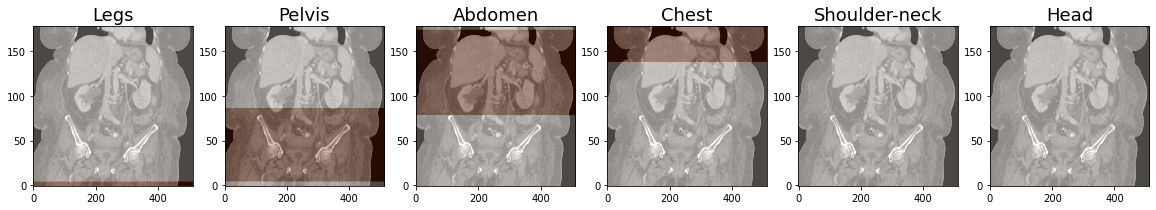

In [ ]:
# Processing series

path_downloaded = '/content/downloaded_data'
path_nifti = '/content/nifti_data'
path_json =  '/content/json_data'
path_nrrd = '/content/nrrd_data'

df = ct_limited_open_a1_r1

seriesuid_all = list(set(df['SeriesInstanceUID'].tolist()))
print('total series:', len(seriesuid_all))

seriesuid_all = ['1.2.826.0.1.3680043.10.474.419639.105799060738901793068313281334']

#for seriesuid in [seriesuid_all[14]]:

#for seriesuid in seriesuid_all[0:25]:
for seriesuid in seriesuid_all:

  print('\n\nSeries %d / %d' %( seriesuid_all.index(seriesuid), len(seriesuid_all)) )

  # clean up from previous iterations and recreate temp directories
  if 1:
    for x in [path_downloaded, path_nifti, path_json, path_nrrd]:
      if os.path.isdir(x):
        try:
          shutil.rmtree(x)
        except OSError as err:
          print("Error: %s : %s" % (x, err.strerror))  
      os.mkdir(x)

  studyuids = list(set(df[df['SeriesInstanceUID']==seriesuid]['StudyInstanceUID'].tolist()))
  if len(studyuids)!=1:
    print('error - not one UID for this series', studyuids)
    print(studyuids)
    1/0
  studyuid = studyuids[0]
  sops = df[ (df['StudyInstanceUID']==studyuid) & (df['SeriesInstanceUID']==seriesuid) ]['SOPInstanceUID'].tolist()

  print(len(sops), seriesuid)

  url_ohif = "https://idc-tester-1.web.app/projects/idc-external-019/locations/us-central1/datasets/midrc/dicomStores/midrc-dicom/study/%s?seriesInstanceUID=%s" % (studyuid,seriesuid)
  print(url_ohif)

  file_gs_uri = "gs://%s/%s/non-axial/%s.json" % (bucket_name, bucket_path, seriesuid)
  #if file_exists_in_bucket(project_name, bucket_name, file_gs_uri):
  #  print("SKIP EXISTING NONAXIAL", seriesuid)
  #  continue

  #file_gs_uri = "gs://%s/%s/%s.json" % (bucket_name, bucket_path, seriesuid)
  #if file_exists_in_bucket(project_name, bucket_name, file_gs_uri):
  #  print("SKIP EXISTING GOOD", seriesuid)
  #  continue

  # download series
  download_series(studyuid, seriesuid, sops, path_downloaded)

  #convert to nifti
  print('converting to NIFTI')
  cmd = 'dcm2niix -z y -m y -o %s  %s ' % (path_nifti, path_downloaded)
  print(cmd)
  os.system(cmd)

  #define nii file to convert to nrrd
  files = glob.glob(os.path.join(path_nifti,"*.nii.gz"))
  x = [len(x) for x in files]
  nii_good = files[np.argmin(x)]
  print(files)
  print('USING ', nii_good)
  for x in files:
    if x!=nii_good:
      print('   Deleted ',x )
      os.remove(x)

  # body part regression
  print('running BPREG')
  bpreg_inference(path_nifti, path_json)

  # Convert image to nrrd and read as numpy array
  print('converting NII to NRRD')
  file_path_nrrd = os.path.join(path_nrrd,  "ct.nrrd")
  log_file_path_nrrd = os.path.join(path_nrrd, 'pypla.log')
  convert_args_ct = {"input" : nii_good, "output-img" : file_path_nrrd}
  verbose = True
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nrrd, **convert_args_ct)
  # read nrrd CT
  ct, ctheader = nrrd.read(file_path_nrrd)
  print(ct.shape)

  # find and rename the json file from BPREG output
  files = glob.glob(os.path.join(path_json,"*.json"))
  if len(files)!=1:
    print('error: not exactly one json file', files)
    1/0
  # rename json file 
  fn = os.path.split(files[0])[-1][:-5]
  print(fn)
  fn_new= seriesuid+'.json'
  # need quotes around filename to escape "bmi>30" etc special characters
  cmd = 'mv "%s" %s' % (files[0], os.path.join(path_json,fn_new))
  print(cmd)
  os.system(cmd)

  # read labels and z-slices for predicted body parts
  fileObject = open(os.path.join(path_json, fn_new), "r")
  jsonContent = fileObject.read()
  aList = json.loads(jsonContent)

  # check for dimension errors in case of Sagittal or Coronal protocol
  image_size_z = ct.shape[2]
  error_z = False
  for (bodypart, zlist) in aList['body part examined'].items():
    print(bodypart, zlist)
    for z in zlist:
      if z >= image_size_z:
        error_z = True
  if error_z:
    print('SKIP Dimension error, Sagittal or Coronal protocol?')

  # if all good, copy BPREG json to the bucket
  if not error_z:
    cmd = "gsutil cp %s/%s gs://%s/%s" % (path_json, fn_new, bucket_name, bucket_path)
    print(cmd)
    os.system(cmd)
  else:
    # copy json to non-axial folders and DO NOT VISUALIZE
    cmd = "gsutil cp %s/%s gs://%s/%s/non-axial" % (path_json, fn_new, bucket_name, bucket_path)
    print(cmd)
    os.system(cmd)
    continue

  # write out nrrd masks for body parts
  for (bodypart, zlist) in aList['body part examined'].items():
      print(bodypart, zlist)
      lmbox = np.zeros(ct.shape,dtype=np.short)
      for z in zlist:
          #lmbox[:,:,512-1-int(z)]=1
          lmbox[:,:,int(z)]=1
      fn = os.path.join(path_nrrd, 'box-%s.nrrd' % bodypart)
      nrrd.write(fn, lmbox,  header = ctheader)

  fnlegs_in ='/content/nrrd_data/box-legs.nrrd'
  fnpelvis_in ='/content/nrrd_data/box-pelvis.nrrd'
  fnabdomen_in ='/content/nrrd_data/box-abdomen.nrrd'
  fnchest_in ='/content/nrrd_data/box-chest.nrrd'
  fnshoulderneck_in ='/content/nrrd_data/box-shoulder-neck.nrrd'
  fnhead_in ='/content/nrrd_data/box-head.nrrd'

  legs, legsheader = nrrd.read(fnlegs_in)
  pelvis, pelvisheader = nrrd.read(fnpelvis_in)
  abdomen, abdomenheader = nrrd.read(fnabdomen_in)
  chest, chestheader = nrrd.read(fnchest_in)
  shoulderneck, shoulderneckheader = nrrd.read(fnshoulderneck_in)
  head, headheader = nrrd.read(fnhead_in)

  # visualize and save to bucket
  print('visualizing')
  fn_png = os.path.join(path_json, '%s.png' % seriesuid)
  visualize_body_parts(fn_png, ct, legs, pelvis, abdomen, chest, shoulderneck, head)
  #!gsutil cp /content/json_data/file_png gs://{bucket_name}/{bucket_path}/
  cmd = "gsutil cp %s gs://%s/%s" % (fn_png, bucket_name, bucket_path)
  print(cmd)
  os.system(cmd)


In [ ]:
!pip install git+https://github.com/JoHof/lungmask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JoHof/lungmask to /tmp/pip-req-build-boh7ju4s
  Running command git clone -q https://github.com/JoHof/lungmask /tmp/pip-req-build-boh7ju4s
     |████████████████████████████████| 1.1 MB 33.0 MB/s 
     |████████████████████████████████| 4.2 MB 35.2 MB/s 
  Created wheel for lungmask: filename=lungmask-0.2.11-py3-none-any.whl size=17456 sha256=d307ef38245e611814a35c2a971dd39d9fee63bb1c4bce1cd6299752d14e13e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-8msgces5/wheels/b7/62/f7/fd172f57224a95cf73efec4a6029c8a78577dab75b949338d1
Successfully built lungmask


In [ ]:
from lungmask import mask
import SimpleITK as sitk

input_image = sitk.ReadImage(file_path_nrrd)
segmentation = mask.apply(input_image) 

100%|██████████| 3/3 [00:00<00:00, 91.09it/s]


In [ ]:
s=np.swapaxes(segmentation,0,2 )

In [ ]:
print(s.shape)
print(ct.shape)

(512, 512, 178)
(512, 512, 178)


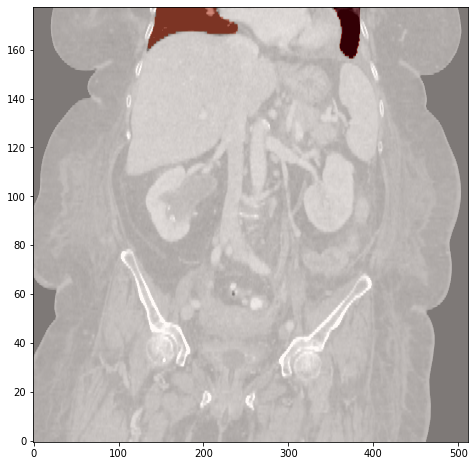

In [ ]:
# Plot CT and lung segmentation 

plt.figure(figsize=[8,8])
xslice = 350
yslice = int(ct.shape[1]/2.) 
zslice = 100

a = ct.shape[0]/ct.shape[2]
o = "lower"

plt.imshow(ct[:,yslice,:].T, cmap='gray', aspect=a, origin = o, vmin = -400, vmax = 400)
plt.imshow(s[:,yslice,:].T, cmap='Reds', alpha=0.5, aspect=a, origin = o)

Text(0.5, 1.0, 'Head')

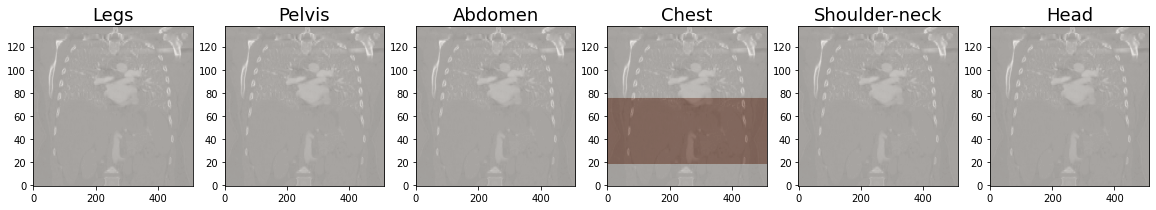

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib.colors import ListedColormap

plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6)
xslice = 350
yslice = 250 
zslice = 100

tissuescmap = ListedColormap(['black', # air
##organs x 19
## https://matplotlib.org/stable/gallery/color/named_colors.html
'darkred', 'orange', 'yellow',     'green', 'mediumslateblue', 'cyan',
'purple','coral', 'tan', 'fuchsia',  'chartreuse', 'deepskyblue', 'skyblue', 'indigo', 'lime', 'gold', 'pink',
 'peru', 'olivedrab'])                            

myslicect = ct[:,yslice,:]
boxslice1 = legs[:,yslice,:]
boxslice2 = pelvis[:,yslice,:]
boxslice3 = abdomen[:,yslice,:]
boxslice4 = chest[:,yslice,:]
boxslice5 = shoulderneck[:,yslice,:]
boxslice6 = head[:,yslice,:]
a = ct.shape[0]/ct.shape[2]
o = "lower"

ax1.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
ax1.imshow(boxslice1.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
ax1.set_title('Legs', fontsize=18)

ax2.imshow(myslicect.T, cmap='gray', aspect = a,origin = o, vmin = -400, vmax = 400)
ax2.imshow(boxslice2.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
ax2.set_title('Pelvis',fontsize=18)

ax3.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
ax3.imshow(boxslice3.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
ax3.set_title('Abdomen',fontsize=18)

ax4.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
ax4.imshow(boxslice4.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
ax4.set_title('Chest',fontsize=18)

ax5.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
ax5.imshow(boxslice5.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
ax5.set_title('Shoulder-neck',fontsize=18)

ax6.imshow(myslicect.T, cmap='gray', aspect = a,origin = o,vmin = -400, vmax = 400)
ax6.imshow(boxslice6.T, cmap="Oranges", alpha = 0.3, aspect=a, origin = o)
ax6.set_title('Head',fontsize=18)

In [ ]:
file_png = '/content/json_data/%s.png' % seriesuid
fig.savefig(file_png)

In [ ]:
#!gsutil cp /content/json_data/file_png gs://{bucket_name}/{bucket_path}/
cmd = "gsutil cp %s gs://%s/%s" % (file_png, bucket_name, bucket_path)
#print(cmd)
os.system(cmd)

0

In [ ]:
# cleanup for the next iteration
  
for x in [path_downloaded, path_nifti, path_nrrd, path_json]:
  if os.path.exists(x):
    try:
      shutil.rmtree(x)
    except OSError as err:
      print("Error: %s : %s" % (x, err.strerror))

In [ ]:
! rm -r /content/json_data/

In [ ]:
# save body part to a single .csv
fn_out = '/content/bpr_by_series.csv'
print(bucket_name, bucket_path)

df = pd.DataFrame(columns = ['SeriesUID','bodypart'])
k=0
storage_client = storage.Client()
blobs = storage_client.list_blobs(bucket_name)
for b in blobs:
  #print(b.name)
  p = os.path.split(b.name)
  # skip non-axial and folders
  if p[0]==bucket_path and p[1].split('.')[-1]=='json':
    k +=1
    seriesuid = '.'.join(p[1].split('.')[:-1])
    #print(b.name)
    contents = storage_client.bucket(bucket_name).blob(b.name).download_as_string()
    jdata = json.loads(contents)
    for (bodypart, zlist) in jdata['body part examined'].items():
      if len(zlist) >0:
        df = df.append( {'SeriesUID': seriesuid, 'bodypart': bodypart }, ignore_index = True)
      if k%10==0:
        print(k,' ', end='')
      if k%120==0:
        print('')
print('\nfiles processed', k)
print(df)
df.to_csv(fn_out, index=False)
cmd = 'gsutil cp %s gs://%s/%s/results-summary/' % (fn_out, bucket_name,bucket_path)
print(cmd)
os.system(cmd)

In [ ]:
file_gs_uri = "gs://%s/%s/%s.json" % (bucket_name, bucket_path, seriesuid)

json_list = glob(os.path.join( pat_dir_path_json,'*.json'))
  print(len(json_list), 'files for this patient')

  for jn in json_list:
    fileObject = open(jn, "r")
    jsonContent = fileObject.read()
    aList = json.loads(jsonContent)

    #print(aList['body part examined'])

    jj = os.path.split(jn)
    jjp = jj[0] # path
    jjn = jj[1] # json file name
    bpfn = os.path.join(jjp, jjn.split('.')[0]+'_bodypart_regr.txt')

    f = open(bpfn,'w')
    for (bodypart, zlist) in aList['body part examined'].items():
      #print(jn)
      print(bodypart, zlist)
      if (len(zlist)>0):
        f.write(bodypart+'\n')
    f.close()
